#Concatenated Input CNN with TWristAR
Uses all accel and bvp with Group 3-fold (hold-one-out) validation on [TWristAR](https://zenodo.org/record/5911808).

This is a slightly cleaned up version of our development code supporting the Fusion of Learned Representations for Multimodal Sensor Data Classification paper which is out for review.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2022

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.




# Imports

In [1]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

# Get TWristAR IR3 X,y,sub arrays using gdrive link share
The notebook uses the intermediate representation of the TWRistAR data directly to support 3-fold (hold-one-subject-out) cross-validation.

In [2]:
!gdown "1BmQ0F9Yws71FNGa7PH7NmHPt4guPavLL&confirm=t" # TWristAR IR3 X,y,sub arrays
t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
unpack_archive('TWristAR_IR3.zip','.','zip')

Downloading...
From: https://drive.google.com/uc?id=1BmQ0F9Yws71FNGa7PH7NmHPt4guPavLL&confirm=t
To: /content/TWristAR_IR3.zip
100% 1.81M/1.81M [00:00<00:00, 184MB/s]


In [3]:
# read in the arrays
X = np.load('X.npy')
y = np.load('y.npy')
sub = np.load('sub.npy')
headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))


 Array    shape          data type
-------  -------------  -----------
X:       (3168, 96, 7)  float64
y:       (3168, 1)      <U10
sub:     (3168, 1)      int64


# Total Accel and BVP only, one-hot encode y.
big X is legacy from "all channels" little x indicates subset.


In [4]:
x_acc = X[:,:,0:4] # accel_x, accel_y, accel_z, accel_ttl
x_bvp = X[:,:,4].reshape(X.shape[0], X.shape[1], 1)

x_combo = X[:,:,0:5] # BVP channel

In [5]:
headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
          ("x_acc:", x_acc.shape, x_acc.dtype),
          ("x_bvp:", x_bvp.shape, x_bvp.dtype),
          ("x_combo:", x_combo.shape, x_combo.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))


 Array     shape          data type
--------  -------------  -----------
X:        (3168, 96, 7)  float64
x_acc:    (3168, 96, 4)  float64
x_bvp:    (3168, 96, 1)  float64
x_combo:  (3168, 96, 5)  float64
y:        (3168, 1)      <U10
sub:      (3168, 1)      int64


# Concatenated Input Model

In [6]:
# base topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

def build_1D_CNN(x_train, y_train, num_filters = 100, k1_size=17, k2_size=17, dropout = 0.5, mpool_size = 2):
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
        layers.Input(shape=x_train[0].shape),
        layers.BatchNormalization(scale=False),
        layers.Conv1D(filters=num_filters, kernel_size=k1_size, activation='relu',input_shape=(n_timesteps,n_features)),
        layers.Dropout(dropout),
        layers.Conv1D(filters=num_filters, kernel_size=k2_size, activation='relu'),
        layers.Dropout(dropout),
        layers.MaxPooling1D(pool_size=mpool_size),
        #layers.GlobalAveragePooling1D(),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ])
  return model 

def train_1D_CNN(model,x_train, y_train, x_test, y_test,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    MAX_EPOCHS = 200): # Max number run unless earlystopping callback fires
    # increasing dropout to 0.8 and higher requires more than 100 epochs
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=20)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=MAX_EPOCHS,
        callbacks=[callback],
        validation_data=(x_test,y_test),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model
model = build_1D_CNN(x_combo, y)
model.summary()
#history = train_1D_CNN(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 5)            15        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 80, 100)           8600      
                                                                 
 dropout (Dropout)           (None, 80, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 100)           170100    
                                                                 
 dropout_1 (Dropout)         (None, 64, 100)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 100)          0         
 )                                                      

## Run a stratified 5-fold group-based cross validation

Fold 0:
Epoch 1/200
67/67 [==============================] - 4s 14ms/step - loss: 0.8753 - accuracy: 0.6366 - val_loss: 1.1576 - val_accuracy: 0.5505
Epoch 2/200
67/67 [==============================] - 0s 7ms/step - loss: 0.4134 - accuracy: 0.8583 - val_loss: 0.9805 - val_accuracy: 0.6932
Epoch 3/200
67/67 [==============================] - 0s 7ms/step - loss: 0.3132 - accuracy: 0.8924 - val_loss: 0.8630 - val_accuracy: 0.6786
Epoch 4/200
67/67 [==============================] - 0s 7ms/step - loss: 0.1831 - accuracy: 0.9383 - val_loss: 0.6562 - val_accuracy: 0.7534
Epoch 5/200
67/67 [==============================] - 0s 7ms/step - loss: 0.1887 - accuracy: 0.9397 - val_loss: 0.6184 - val_accuracy: 0.7738
Epoch 6/200
67/67 [==============================] - 0s 6ms/step - loss: 0.1378 - accuracy: 0.9556 - val_loss: 0.7310 - val_accuracy: 0.7291
Epoch 7/200
67/67 [==============================] - 0s 6ms/step - loss: 0.1142 - accuracy: 0.9630 - val_loss: 0.5636 - val_accuracy: 0.8136
Epoc

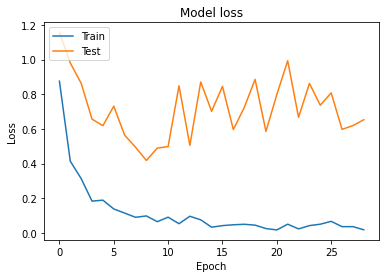

Fold 1:
Epoch 1/200
65/65 [==============================] - 2s 14ms/step - loss: 0.8464 - accuracy: 0.6413 - val_loss: 1.4232 - val_accuracy: 0.3841
Epoch 2/200
65/65 [==============================] - 0s 6ms/step - loss: 0.4294 - accuracy: 0.8344 - val_loss: 1.5289 - val_accuracy: 0.4125
Epoch 3/200
65/65 [==============================] - 0s 7ms/step - loss: 0.2811 - accuracy: 0.9109 - val_loss: 0.9441 - val_accuracy: 0.6654
Epoch 4/200
65/65 [==============================] - 0s 6ms/step - loss: 0.2384 - accuracy: 0.9191 - val_loss: 0.9285 - val_accuracy: 0.6068
Epoch 5/200
65/65 [==============================] - 0s 7ms/step - loss: 0.1565 - accuracy: 0.9456 - val_loss: 1.1028 - val_accuracy: 0.5426
Epoch 6/200
65/65 [==============================] - 0s 6ms/step - loss: 0.1208 - accuracy: 0.9639 - val_loss: 1.0178 - val_accuracy: 0.6489
Epoch 7/200
65/65 [==============================] - 0s 7ms/step - loss: 0.1157 - accuracy: 0.9677 - val_loss: 1.0541 - val_accuracy: 0.5940
Epoc

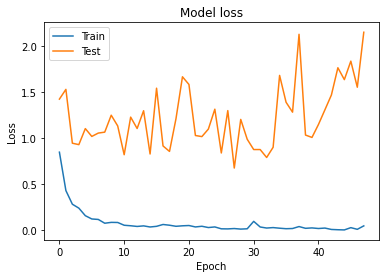

Fold 2:
Epoch 1/200
67/67 [==============================] - 2s 14ms/step - loss: 0.8594 - accuracy: 0.6304 - val_loss: 0.8579 - val_accuracy: 0.5731
Epoch 2/200
67/67 [==============================] - 0s 6ms/step - loss: 0.4253 - accuracy: 0.8501 - val_loss: 0.6076 - val_accuracy: 0.7736
Epoch 3/200
67/67 [==============================] - 0s 6ms/step - loss: 0.3186 - accuracy: 0.8835 - val_loss: 0.4574 - val_accuracy: 0.8118
Epoch 4/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2029 - accuracy: 0.9302 - val_loss: 0.4899 - val_accuracy: 0.8080
Epoch 5/200
67/67 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9453 - val_loss: 0.4143 - val_accuracy: 0.8338
Epoch 6/200
67/67 [==============================] - 0s 6ms/step - loss: 0.1302 - accuracy: 0.9538 - val_loss: 0.4281 - val_accuracy: 0.8691
Epoch 7/200
67/67 [==============================] - 0s 7ms/step - loss: 0.1239 - accuracy: 0.9609 - val_loss: 0.4601 - val_accuracy: 0.8214
Epoc

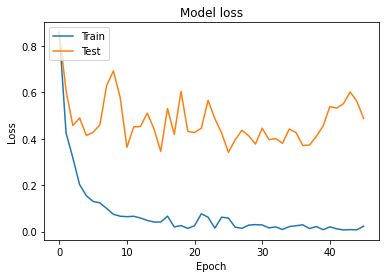

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.6527104377746582 - Accuracy: 84.07766819000244%
> Fold 1 - Accuracy: 84.07766819000244%
> Fold 2 - Loss: 2.1497690677642822 - Accuracy: 61.50320768356323%
> Fold 2 - Accuracy: 61.50320768356323%
> Fold 3 - Loss: 0.4873877167701721 - Accuracy: 94.93792057037354%
> Fold 3 - Accuracy: 94.93792057037354%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 80.17293214797974 (+- 13.926120041712098)
------------------------------------------------------------------------


In [7]:
# original source NNCLR_Multi_CNN_Funct_classifier_TWristAR_and_UE4W_4.ipynb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder

import sys

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
y_pred_per_fold = []
y_test_per_fold = []

skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X, y, groups=sub)):
    print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")
    # print(f"  Groups:   index={sub_labeled[test_index]}")

    x_train = x_combo[train_index]
    x_test = x_combo[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    enc = OneHotEncoder(categories='auto', sparse=False)
    y_train = enc.fit_transform(y_train)
    y_test = enc.fit_transform(y_test)

    model = build_1D_CNN(x_train, y_train)
    history, model = train_1D_CNN(model, x_train, y_train,
                                          x_test, y_test)  
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1] 

    acc_per_fold.append(val_acc * 100)
    loss_per_fold.append(val_loss)

    y_pred = model.predict(x_test, verbose = 0)

    y_pred = np.argmax(y_pred, axis=1)
    y_pred_per_fold.append(y_pred)
    y_test_per_fold.append(np.argmax(y_test, axis=1))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
#print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Confusion matrix, without normalization
[[431   0   1   5  44   9]
 [ 22 349   4   7 125  13]
 [  0   0 489  19   7   9]
 [  9   1  22 468  15  13]
 [ 16   3   5   3 502  39]
 [ 56  17  16   6 151 292]]


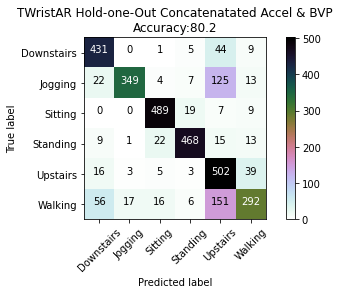

In [11]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

y_pred = np.concatenate(y_pred_per_fold)
y_test = np.concatenate(y_test_per_fold)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
title = 'TWristAR Hold-one-Out Concatenatated Accel & BVP\n'
title += 'Accuracy:{0:.1f}'.format(np.mean(acc_per_fold))
plot_confusion_matrix(cm, classes=t_names, title=title, cmap='cubehelix_r')